# import libraries

In [24]:
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Read in project_adult.csv and project_validation_inputs.csv

In [ ]:
#reading in the project adult data 
file_path = 'project_adult.csv'

try:
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'project_adult.csv'. First 5 rows:
        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  capital-ga

In [ ]:
# read in the project validation data
file_path = 'project_validation_inputs.csv'
try:
    validation = pd.read_csv(file_path, header=None, encoding='utf-8')
    print(f"Successfully loaded '{file_path}'. First 5 rows:")
    print(validation.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty or contains no data.")
except pd.errors.ParserError as e:
    print(f"Error: A parsing error occurred while reading '{file_path}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully loaded 'project_validation_inputs.csv'. First 5 rows:
        0    1          2       3             4              5   \
0      NaN  age  workclass  fnlwgt     education  education-num   
1  14160.0   27    Private  160178  Some-college             10   
2  27048.0   45  State-gov   50567       HS-grad              9   
3  28868.0   29    Private  185908     Bachelors             13   
4   5667.0   30    Private  190040     Bachelors             13   

                   6                  7              8      9       10  \
0      marital-status         occupation   relationship   race     sex   
1            Divorced       Adm-clerical  Not-in-family  White  Female   
2  Married-civ-spouse    Exec-managerial           Wife  White  Female   
3  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
4       Never-married  Machine-op-inspct  Not-in-family  White  Female   

             11            12              13              14  
0  capital-gain  capi

## Preprocess data

In [ ]:
# process and standardize data
def preprocess_data(df, is_train = True):

    print(df.head())

    # For training data 
    if is_train:
        # correct column names
        new_column_names = ['id','age', 'work_class', 'fnlwgt', 'education', 'education_num',
                       'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain',
                        'capital_loss', 'hours_per_week', 'native_country','income']
        df.columns = new_column_names

        # Handle missing values
        df =df.dropna()

        #remove fnlwgt and id column
        df = df.drop(columns=['fnlwgt'], axis=1)
        df = df.drop(columns=['id'], axis=1)

        # Binarize the target variable
        df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

        # Standardize cateforical features
        categorical_cols = ['work_class', 'education', 'marital_status', 'occupation',
                        'relationship', 'race', 'sex', 'native_country']
        le = LabelEncoder()
        for col in categorical_cols:
            df[col] = le.fit_transform(df[col])

        # Standardize numerical features
        numeric_cols = ['age','education_num','capital_gain','capital_loss','hours_per_week']
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        # Separate features and target
        X = df.drop(columns=['income'], axis=1)
        y = df[['income']]
        return X, y
    
    # For validation data
    else:
        # correct column names
        new_column_names = ['id','age', 'work_class', 'fnlwgt', 'education', 'education_num',
                       'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain',
                        'capital_loss', 'hours_per_week', 'native_country']
        df.columns = new_column_names

        # Handle missing values 
        df = df.dropna()

        # Standardize cateforical features
        categorical_cols = ['work_class', 'education', 'marital_status', 'occupation',
                        'relationship', 'race', 'sex', 'native_country']
        le = LabelEncoder()
        for col in categorical_cols:
            df[col] = le.fit_transform(df[col])
        
        #Standardize numerical features
        numeric_cols = ['age','education_num','capital_gain','capital_loss','hours_per_week']
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

        return df

In [ ]:
X,y = preprocess_data(df, True)

# Save training feature column order for later use
feature_columns = X.columns

        0    1                 2       3          4              5   \
0      NaN  age         workclass  fnlwgt  education  education-num   
1   5514.0   33         Local-gov  198183  Bachelors             13   
2  19777.0   36           Private   86459  Assoc-voc             11   
3  10781.0   58  Self-emp-not-inc  203039        9th              5   
4  32240.0   21           Private  180190  Assoc-voc             11   

                   6                7              8      9       10  \
0      marital-status       occupation   relationship   race     sex   
1       Never-married   Prof-specialty  Not-in-family  White  Female   
2  Married-civ-spouse  Exec-managerial        Husband  White    Male   
3           Separated     Craft-repair  Not-in-family  White    Male   
4  Married-civ-spouse  Farming-fishing        Husband  White    Male   

             11            12              13              14      15  
0  capital-gain  capital-loss  hours-per-week  native-country  incom

In [ ]:
validation = preprocess_data(validation, False)

# Reindex validation columns to match training features
validation = validation.reindex(columns=feature_columns, fill_value=0)

        0    1          2       3             4              5   \
0      NaN  age  workclass  fnlwgt     education  education-num   
1  14160.0   27    Private  160178  Some-college             10   
2  27048.0   45  State-gov   50567       HS-grad              9   
3  28868.0   29    Private  185908     Bachelors             13   
4   5667.0   30    Private  190040     Bachelors             13   

                   6                  7              8      9       10  \
0      marital-status         occupation   relationship   race     sex   
1            Divorced       Adm-clerical  Not-in-family  White  Female   
2  Married-civ-spouse    Exec-managerial           Wife  White  Female   
3  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
4       Never-married  Machine-op-inspct  Not-in-family  White  Female   

             11            12              13              14  
0  capital-gain  capital-loss  hours-per-week  native-country  
1             0         

/var/folders/d1/pkkj1yg97vd_wwkpsfbyc2480000gn/T/ipykernel_8005/416825331.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
/var/folders/d1/pkkj1yg97vd_wwkpsfbyc2480000gn/T/ipykernel_8005/416825331.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
/var/folders/d1/pkkj1yg97vd_wwkpsfbyc2480000gn/T/ipykernel_8005/416825331.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [ ]:
# Sigmoid activation function
def sigmoid(z):
 return 1. / (1. + np.exp(-z))

# One-hot encoding function
def int_to_onehot(y, num_labels):
 ary = np.zeros((y.shape[0], num_labels))
 for i, val in enumerate(y):
    ary[i, val] = 1
 return ary

## Train/test split + SMOTE

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.asarray(X_train)
X_test  = np.asarray(X_test)
y_train = np.asarray(y_train).ravel()
y_test  = np.asarray(y_test).ravel()

In [ ]:
# Handle class imbalance using SMOTE
print("Before SMOTE - Class distribution:", np.bincount(y_train))
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("After SMOTE - Class distribution:", np.bincount(y_train_balanced))

# Create proper train/validation split
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42, stratify=y_train_balanced
)

Before SMOTE - Class distribution: [15774  5064]
After SMOTE - Class distribution: [15774 15774]


### Define MLP class

In [ ]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes
        
        # Better weight initialization (Xavier/Glorot)
        rng = np.random.RandomState(random_seed)
        scale_h = np.sqrt(2.0 / (num_features + num_hidden))
        scale_out = np.sqrt(2.0 / (num_hidden + num_classes))
        
        self.weight_h = rng.normal(loc=0.0, scale=scale_h, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        self.weight_out = rng.normal(loc=0.0, scale=scale_out, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
        # For momentum
        self.momentum_w_h = np.zeros_like(self.weight_h)
        self.momentum_b_h = np.zeros_like(self.bias_h)
        self.momentum_w_out = np.zeros_like(self.weight_out)
        self.momentum_b_out = np.zeros_like(self.bias_out)
    
    def forward(self, X):
        # Use ReLU for hidden layer (better for deep networks)
        z_h = np.dot(X, self.weight_h.T) + self.bias_h
        a_h = np.maximum(0, z_h)  # ReLU activation
        
        # Sigmoid for output (binary classification)
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    def backward(self, X, a_h, a_out, y, lambda_reg=0.001):
        y_onehot = int_to_onehot(y, self.num_classes)
        
        # Output layer gradients
        d_loss__d_a_out = 2.0 * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1.0 - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        
        # Add L2 regularization
        d_loss__dw_out = np.dot(delta_out.T, a_h) + lambda_reg * self.weight_out
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        # Hidden layer gradients (ReLU derivative)
        d_loss__a_h = np.dot(delta_out, self.weight_out)
        d_a_h__d_z_h = (a_h > 0).astype(float)  # ReLU derivative
        delta_h = d_loss__a_h * d_a_h__d_z_h
        
        d_loss__d_w_h = np.dot(delta_h.T, X) + lambda_reg * self.weight_h
        d_loss__d_b_h = np.sum(delta_h, axis=0)
        
        return d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h

In [ ]:
# Ensure consistent number of features
num_features = X_train.shape[1]
mlp = NeuralNetMLP(num_features=num_features,
                   num_hidden=64,
                   num_classes=2,
                   random_seed=42)

In [ ]:
# Initialize the Neural Network MLP model
model = NeuralNetMLP(num_features=X_train.shape[1], num_hidden=50,
                     num_classes=2, random_seed=123)

In [ ]:
# Printing test accuracy
_, y_pred_prob = mlp.forward(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7681381957773512

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4004
           1       0.33      0.00      0.00      1206

    accuracy                           0.77      5210
   macro avg       0.55      0.50      0.44      5210
weighted avg       0.67      0.77      0.67      5210



### FULL BATCH

In [ ]:
# create function that computes MSE and accuracy based on the full batch
def compute_mse_and_acc(nnet, X, y, num_labels=2):
    mse, correct_pred, num_examples = 0., 0, 0

    _, probas = nnet.forward(X)
    predicted_labels = np.argmax(probas, axis=1)

    onehot_targets = int_to_onehot(y, num_labels=num_labels)
    loss = np.mean((onehot_targets - probas)**2)
    correct_pred += (predicted_labels == y).sum()

    num_examples += y.shape[0]
    mse += loss

    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
# Compute initial MSE and accuracy on test data
mse, acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.4
Initial test accuracy: 76.8%


In [ ]:
# function to train "model" based on the training and test data to find weights that improves performance
def train_fullbatch(model, X_train, y_train, X_test, y_test, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_test_acc = []

    for e in range(num_epochs):

        #### Compute outputs ####
        a_h, a_out = model.forward(X_train)

        #### Compute gradients ####
        d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
            model.backward(X_train, a_h, a_out, y_train)

        #### Update weights ####
        model.weight_h -= learning_rate * d_loss__d_w_h
        model.bias_h -= learning_rate * d_loss__d_b_h
        model.weight_out -= learning_rate * d_loss__d_w_out
        model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
        train_acc, test_acc = train_acc*100, test_acc*100
        epoch_train_acc.append(train_acc)
        epoch_test_acc.append(test_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_test_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_test_acc = train_fullbatch(
    model, X_train, y_train, X_test, y_test,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.85%
Epoch: 002/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.85%
Epoch: 003/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.85%
Epoch: 004/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.85%
Epoch: 005/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 006/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 007/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 008/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 009/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 010/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 011/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 012/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 013/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc: 76.87%
Epoch: 014/050 | Train MSE: 0.24 | Train Acc: 75.69% | Test Acc:

In [ ]:
'''# Train final model on balanced data
final_model = NeuralNetMLP(
    num_features=X_train_final.shape[1],
    num_hidden=128,
    num_classes=2,
    random_seed=42
)

print("Training final model...")
train_losses, val_losses, train_accs, val_accs = train_with_early_stopping(
    final_model, X_train_final, y_train_final, X_val_final, y_val_final,
    num_epochs=200, learning_rate=0.01, patience=15
)

# Evaluate on test set
_, test_probas = final_model.forward(X_test)
test_pred = np.argmax(test_probas, axis=1)

print("\n=== Final Model Performance ===")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")
print(f"Test Classification Report:\n{classification_report(y_test, test_pred)}")

# Generate validation predictions
_, val_pred_probas = final_model.forward(val_X)
val_pred = np.argmax(val_pred_probas, axis=1)

# Check class distribution in predictions
print(f"Validation predictions - Class 0: {(val_pred == 0).sum()}, Class 1: {(val_pred == 1).sum()}")

# Transform as required (1 if '>50K' else -1)
val_pred_transformed = np.where(val_pred == 1, 1, -1)

# Save to CSV
pd.DataFrame(val_pred_transformed, columns=['predictions']).to_csv("Group_2_MLP_PredictedOutputs.csv", index=False)'''

SyntaxError: incomplete input (2629969169.py, line 34)

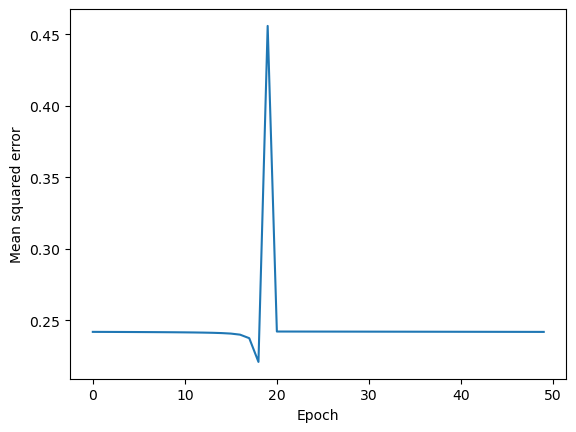

In [ ]:
# Evaluate MLP with fullbatch performance
# Plot Epoch vs MSE
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

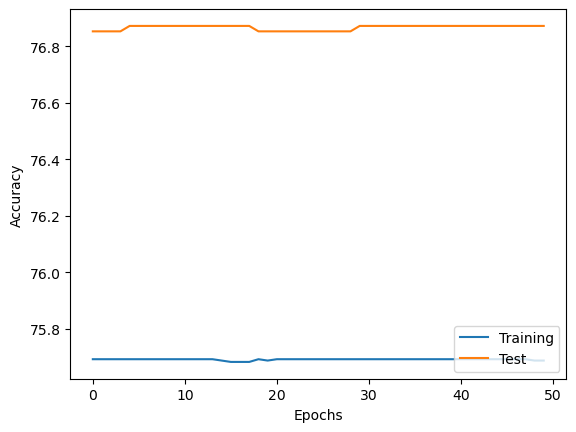

In [ ]:
# plot Epoch vs accuracy for training and validation test
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_test_acc)), epoch_test_acc,
         label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

### MINI BATCH

In [ ]:
# Training the model with mini-batch gradient descent
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0]) # row indices
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        if isinstance(X, pd.DataFrame):  # Check if X is a pandas DataFrame
            yield X.iloc[batch_idx], y.iloc[batch_idx]
        else:  # Assume X is a NumPy array
            yield X[batch_idx], y[batch_idx]

for epoch in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break  # Process the first mini-batch and exit the loop
    break  # Exit after the first epoch
print(X_train_mini.shape, y_train_mini.shape)

(100, 13) (100,)


In [ ]:
# create functions to compute loss and accuracy
# modified to use traditional use of train, test, and valid
def mse_loss(targets, probas, num_labels=2):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_test)
mse = mse_loss(y_test, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_test, predicted_labels)

print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.2
Initial test accuracy: 76.9%


In [ ]:
# create function that computes MSE and accuracy based on the minibatch
def compute_mse_and_acc(nnet, X, y, num_labels=2, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
# print initial MSE and initial test accuracy
mse, acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Initial test MSE: {mse:.1f}')
print(f'Initial test accuracy: {acc*100:.1f}%')

Initial test MSE: 0.2
Initial test accuracy: 76.9%


In [ ]:
# train mini batch
def train_minibatch(model, X_train, y_train, X_test, y_test, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_test_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            # compute output
            a_h, a_out = model.forward(X_train_mini)

            # compute gradients
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #update weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        # epoch logging
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
        train_acc, test_acc = train_acc*100, test_acc*100
        epoch_train_acc.append(train_acc)
        epoch_test_acc.append(test_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_test_acc

In [ ]:
# performing training of "model" on training and test data
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_test_acc = train_minibatch(
    model, X_train, y_train, X_test, y_test,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.24 | Train Acc: 75.72% | Test Acc: 76.81%
Epoch: 002/050 | Train MSE: 0.24 | Train Acc: 75.74% | Test Acc: 76.87%


Epoch: 003/050 | Train MSE: 0.24 | Train Acc: 75.73% | Test Acc: 76.87%
Epoch: 004/050 | Train MSE: 0.24 | Train Acc: 75.78% | Test Acc: 76.92%
Epoch: 005/050 | Train MSE: 0.24 | Train Acc: 75.78% | Test Acc: 76.87%
Epoch: 006/050 | Train MSE: 0.24 | Train Acc: 75.80% | Test Acc: 76.92%
Epoch: 007/050 | Train MSE: 0.24 | Train Acc: 75.81% | Test Acc: 76.94%
Epoch: 008/050 | Train MSE: 0.24 | Train Acc: 75.80% | Test Acc: 76.90%
Epoch: 009/050 | Train MSE: 0.24 | Train Acc: 75.84% | Test Acc: 76.94%
Epoch: 010/050 | Train MSE: 0.17 | Train Acc: 77.95% | Test Acc: 78.83%
Epoch: 011/050 | Train MSE: 0.15 | Train Acc: 78.52% | Test Acc: 79.73%
Epoch: 012/050 | Train MSE: 0.16 | Train Acc: 77.38% | Test Acc: 76.75%
Epoch: 013/050 | Train MSE: 0.15 | Train Acc: 77.90% | Test Acc: 78.96%
Epoch: 014/050 | Train MSE: 0.15 | Train Acc: 76.96% | Test Acc: 75.75%
Epoch: 015/050 | Train MSE: 0.13 | Train Acc: 81.22% | Test Acc: 81.90%
Epoch: 016/050 | Train MSE: 0.14 | Train Acc: 79.16% | Test Acc:

### Parameter tuning

In [ ]:
# Parameter Tuning Sweep for MLP
results = []

hidden_layer_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.05, 0.01, 0.001]
epochs = 50

for hidden in hidden_layer_sizes:
    for lr in learning_rates:
        print(f"\nTraining MLP: hidden={hidden}, lr={lr}")

        mlp_tune = NeuralNetMLP(
            num_features=X_train.shape[1],
            num_hidden=hidden,
            num_classes=2,
            random_seed=42
        )

        losses = []
        for epoch in range(epochs):
            a_h, a_out = mlp_tune.forward(X_train)
            loss = np.mean((a_out - int_to_onehot(y_train, 2))**2)
            losses.append(loss)

            grad_w_out, grad_b_out, grad_w_h, grad_b_h = mlp_tune.backward(X_train, a_h, a_out, y_train)
            mlp_tune.weight_out -= lr * grad_w_out
            mlp_tune.bias_out   -= lr * grad_b_out
            mlp_tune.weight_h   -= lr * grad_w_h
            mlp_tune.bias_h     -= lr * grad_b_h

        # Evaluate performance on test data
        _, y_pred_prob = mlp_tune.forward(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        acc = accuracy_score(y_test, y_pred)
        recall_1 = classification_report(y_test, y_pred, output_dict=True)['1']['recall']

        results.append({
            "hidden": hidden,
            "lr": lr,
            "accuracy": acc,
            "recall_class1": recall_1
        })
        print(f"Accuracy: {acc:.4f}, Class 1 Recall: {recall_1:.4f}")

# Convert results to DataFrame for easy comparison
tuning_results = pd.DataFrame(results)
print("\nParameter Tuning Results")
print(tuning_results.sort_values(by="accuracy", ascending=False))



Training MLP: hidden=16, lr=0.1


Accuracy: 0.7827, Class 1 Recall: 0.2272

Training MLP: hidden=16, lr=0.05
Accuracy: 0.7687, Class 1 Recall: 0.0365

Training MLP: hidden=16, lr=0.01
Accuracy: 0.7672, Class 1 Recall: 0.0166

Training MLP: hidden=16, lr=0.001
Accuracy: 0.7666, Class 1 Recall: 0.0083

Training MLP: hidden=32, lr=0.1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7685, Class 1 Recall: 0.0000

Training MLP: hidden=32, lr=0.05


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7685, Class 1 Recall: 0.0000

Training MLP: hidden=32, lr=0.01
Accuracy: 0.7678, Class 1 Recall: 0.0116

Training MLP: hidden=32, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7685, Class 1 Recall: 0.0000

Training MLP: hidden=64, lr=0.1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7685, Class 1 Recall: 0.0000

Training MLP: hidden=64, lr=0.05


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7685, Class 1 Recall: 0.0000

Training MLP: hidden=64, lr=0.01
Accuracy: 0.7653, Class 1 Recall: 0.0083

Training MLP: hidden=64, lr=0.001
Accuracy: 0.7651, Class 1 Recall: 0.0216

Training MLP: hidden=128, lr=0.1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7685, Class 1 Recall: 0.0000

Training MLP: hidden=128, lr=0.05


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7685, Class 1 Recall: 0.0000

Training MLP: hidden=128, lr=0.01
Accuracy: 0.7683, Class 1 Recall: 0.0000

Training MLP: hidden=128, lr=0.001
Accuracy: 0.7685, Class 1 Recall: 0.0000

=== Parameter Tuning Results ===
    hidden     lr  accuracy  recall_class1
0       16  0.100  0.782726       0.227197
1       16  0.050  0.768714       0.036484
4       32  0.100  0.768522       0.000000
5       32  0.050  0.768522       0.000000
7       32  0.001  0.768522       0.000000
8       64  0.100  0.768522       0.000000
9       64  0.050  0.768522       0.000000
12     128  0.100  0.768522       0.000000
13     128  0.050  0.768522       0.000000
15     128  0.001  0.768522       0.000000
14     128  0.010  0.768330       0.000000
6       32  0.010  0.767754       0.011609
2       16  0.010  0.767179       0.016584
3       16  0.001  0.766603       0.008292
10      64  0.010  0.765259       0.008292
11      64  0.001  0.765067       0.021559


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model selection & final training

In [ ]:
# Use best parameters from above
best_hidden = 16
best_lr = 0.1

final_model = NeuralNetMLP(
    num_features=X_train.shape[1],
    num_hidden=best_hidden,
    num_classes=2,
    random_seed=42
)

# Train for more epochs with the optimal learning rate
losses = []
for epoch in range(200):  # More epochs
    a_h, a_out = final_model.forward(X_train)
    loss = np.mean((a_out - int_to_onehot(y_train, 2))**2)
    losses.append(loss)
    
    grad_w_out, grad_b_out, grad_w_h, grad_b_h = final_model.backward(X_train, a_h, a_out, y_train)
    final_model.weight_out -= best_lr * grad_w_out
    final_model.bias_out -= best_lr * grad_b_out
    final_model.weight_h -= best_lr * grad_w_h
    final_model.bias_h -= best_lr * grad_b_h
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch: {epoch+1}/200, Loss: {loss:.4f}")

Epoch: 20/200, Loss: 0.2124
Epoch: 40/200, Loss: 0.1822
Epoch: 60/200, Loss: 0.1789
Epoch: 80/200, Loss: 0.1743
Epoch: 100/200, Loss: 0.1787
Epoch: 120/200, Loss: 0.1983
Epoch: 140/200, Loss: 0.1825
Epoch: 160/200, Loss: 0.1561
Epoch: 180/200, Loss: 0.1887
Epoch: 200/200, Loss: 0.1828


In [ ]:
# train w momentum to stabalize accuracy
def train_with_momentum(model, X_train, y_train, num_epochs=200, lr=0.1, momentum=0.9):
    losses = []
    
    # Initialize momentum buffers
    v_w_out = np.zeros_like(model.weight_out)
    v_b_out = np.zeros_like(model.bias_out)
    v_w_h = np.zeros_like(model.weight_h)
    v_b_h = np.zeros_like(model.bias_h)
    
    for epoch in range(num_epochs):
        a_h, a_out = model.forward(X_train)
        loss = np.mean((a_out - int_to_onehot(y_train, 2))**2)
        losses.append(loss)
        
        grad_w_out, grad_b_out, grad_w_h, grad_b_h = model.backward(X_train, a_h, a_out, y_train)
        
        # Update with momentum
        v_w_out = momentum * v_w_out + lr * grad_w_out
        v_b_out = momentum * v_b_out + lr * grad_b_out
        v_w_h = momentum * v_w_h + lr * grad_w_h
        v_b_h = momentum * v_b_h + lr * grad_b_h
        
        model.weight_out -= v_w_out
        model.bias_out -= v_b_out
        model.weight_h -= v_w_h
        model.bias_h -= v_b_h
        
        if (epoch + 1) % 40 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")
    
    return losses

# Train with momentum
best_model = NeuralNetMLP(num_features=X_train.shape[1], num_hidden=16, num_classes=2, random_seed=42)
losses = train_with_momentum(best_model, X_train, y_train, lr=0.05, momentum=0.9)

Epoch 40/200, Loss: 0.2312
Epoch 80/200, Loss: 0.1621
Epoch 120/200, Loss: 0.1368
Epoch 160/200, Loss: 0.1308
Epoch 200/200, Loss: 0.1253


In [ ]:
# Train your best model (hidden=16, lr=0.1) on full training data
best_model = NeuralNetMLP(
    num_features=X_train.shape[1],
    num_hidden=16,
    num_classes=2,
    random_seed=42
)

# Train
for epoch in range(200):
    a_h, a_out = best_model.forward(X_train)
    loss = np.mean((a_out - int_to_onehot(y_train, 2))**2)
    
    grad_w_out, grad_b_out, grad_w_h, grad_b_h = best_model.backward(X_train, a_h, a_out, y_train)
    best_model.weight_out -= 0.1 * grad_w_out
    best_model.bias_out -= 0.1 * grad_b_out
    best_model.weight_h -= 0.1 * grad_w_h
    best_model.bias_h -= 0.1 * grad_b_h
    
    if (epoch + 1) % 40 == 0:
        print(f"Epoch {epoch+1}/200, Loss: {loss:.4f}")

# validation predictions
_, val_pred_prob = best_model.forward(val_X)
val_pred = np.argmax(val_pred_prob, axis=1)

#  class distribution
print(f"Excel output predictions  - Class 0: {(val_pred == 0).sum()}, Class 1: {(val_pred == 1).sum()}")

# Transform and save
val_pred_transformed = np.where(val_pred == 1, 1, -1)
pd.DataFrame(val_pred_transformed, columns=['predictions']).to_csv("Group_2_MLP_PredictedOutputs.csv", index=False)

Epoch 40/200, Loss: 0.1822
Epoch 80/200, Loss: 0.1743
Epoch 120/200, Loss: 0.1983
Epoch 160/200, Loss: 0.1561
Epoch 200/200, Loss: 0.1828
Excel output predictions  - Class 0: 5488, Class 1: 1025


### Final evaluation & predictions

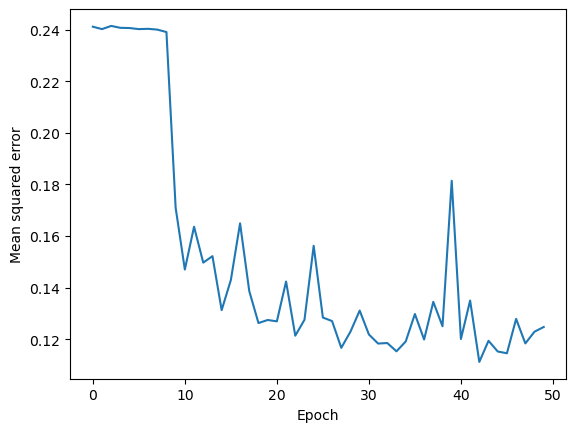

In [ ]:
# evaluate MLP with minibatch performance
# plot Epoch vs MSE
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

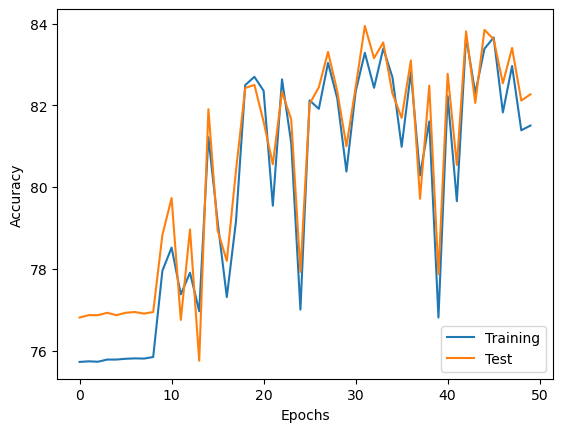

In [ ]:
# plot Epoch vs accuracy for training and validation test
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_test_acc)), epoch_test_acc,
         label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

## Model comparison

In [ ]:
results = {
    "Full-batch MLP ": 0.768,
    "Mini-batch MLP": 0.833
}

best_model = max(results, key=results.get)
print("Model Accuracies:")
for k, v in results.items():
    print(f"{k}: {v*100:.2f}%")

print(f"\nBest model: {best_model} with accuracy {results[best_model]*100:.2f}%")

Model Accuracies:
Full-batch MLP : 76.80%
Mini-batch MLP: 83.30%

Best model: Mini-batch MLP with accuracy 83.30%


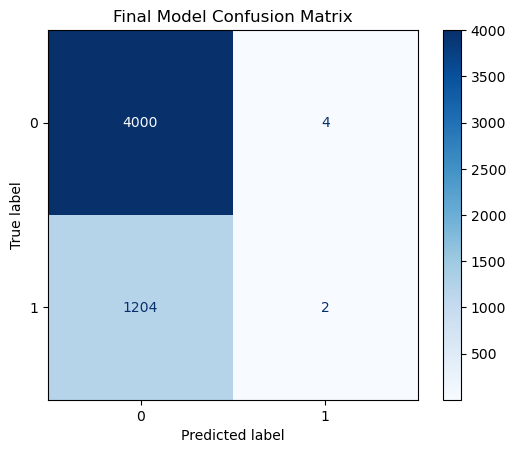

In [ ]:
_, y_pred_prob = mlp.forward(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.title("Final Model Confusion Matrix")
plt.show()